# Convergence test Dynamic Power Iteration with Momentum

In [1]:
from mpi4py import MPI
from dolfinx import *
from dolfinx import mesh, fem, default_scalar_type
import numpy as np
from slepc4py   import SLEPc
from dolfinx.fem.petsc import assemble_matrix
from mshr import *
import basix, ufl, os
import time
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np

In [ ]:
PETSc.

In [2]:
from petsc4py import PETSc
import numpy as np
from petsc4py import PETSc
import numpy as np

def gen_power_it_dynamic_momentum(A, B, v0, tol=1e-8, max_iter=1000):
    '''
    Dynamic power itetration with momentum to solver the generalized eigenvalue problem Ax = lambda Bx

    Input:
    - A  petc.mat
    - B, spd  petc.mat
    - v0 petc.vec

    Output:
    - lambda: largest eigenvalue,  multiplication factor
    - x: eigenvector corresponding to the largest eigenvalue
    - k: number of iterations
    - res: residuals list
    '''
    res = []

    ksp = PETSc.KSP().create(A.getComm())
    ksp.setOperators(B)
    ksp.setType('cg')
    ksp.getPC().setType('gamg')
    ksp.setTolerances(rtol=1e-8, max_it =1000)
    ksp.setFromOptions()
    ksp.setUp()

    v   = B.createVecRight()
    rhs = A.createVecLeft()
    Ax = A.createVecLeft()
    Bx = B.createVecLeft()
    #r    = A.createVecLeft()

    def Bnorm(x):
        y = B.createVecLeft()
        B.mult(x, y)
        q = x.dot(y)                       
        return float(np.sqrt(q))

    
    def solve_B(rhs, y):
        '''
        Preconditioned lineal solver
        '''
        y.set(0.0)
        ksp.solve(rhs, y)
        return y

    # Inicialización
    h0 = Bnorm(v0)
    x0 = v0.copy()
    x0.scale(1.0/h0)
    #rhs = A.createVecLeft()
    A.mult(x0, rhs)    
    #v   = B.createVecRight()     
    v1_vec = solve_B(rhs,v)

    # k = 0 ----------------------------------

    # h1
    h1 = Bnorm(v1_vec)

    # x1
    x_km1 = v1_vec.copy()
    x_km1.scale(1.0/h1)

    # lambda1
    #Ax = A.createVecLeft()
    A.mult(x_km1, Ax)
    Bx = B.createVecLeft()
    B.mult(x_km1, Bx)
    lam1 = float((x_km1.dot(Ax)))

    #d1
    r = Ax.copy()
    #r.copy(Ax)
    r.axpy(-lam1, Bx)
    d_prev = r.norm()
    res.append(d_prev)

    if d_prev < tol: 
        return lam1, x_km1, 1, res

    # v1
    #rhs = A.createVecLeft()
    A.mult(x_km1, rhs)
    v2_vec = solve_B(rhs,v)

    # k = 1 --------------------------------

    #h2
    h_k = Bnorm(v2_vec)
    x_k = v2_vec.copy()
    x_k.scale(1.0/h_k)

    # lambda 2
    #Ax = A.createVecLeft()
    A.mult(x_k, Ax)
    #Bx = B.createVecLeft()
    B.mult(x_k, Bx)
    lam_k = float((x_k.dot(Ax)))

    #d2 residual
    r = Ax.copy()
    #r.copy(Ax)
    r.axpy(-lam_k, Bx)
    d_k = r.norm()
    res.append(d_k)
    if d_k < tol: 
        return lam_k, x_k, 2, res

    # redefine parameters
    r_k = min(d_k/d_prev, 1.0)
    k = 2

    # k >= 2 --------------------------------------------------

    while k < max_iter:

        # beta_k
        beta_k = (lam_k**2) * (r_k**2) / 4.0

        #v_{k+1}
        #rhs = A.createVecLeft()
        A.mult(x_k, rhs)
        v_kp1 = solve_B(rhs,v) 

        # u_{k+1}
        u_kp1 = v_kp1.copy()
        u_kp1.axpy(-(beta_k / h_k), x_km1)

        # h_{k+1}
        h_kp1 = Bnorm(u_kp1)

        # x_{k+1}
        x_kp1 = u_kp1.copy()
        x_kp1.scale(1.0/h_kp1)

        # lambda_{k+1}
        #Ax = A.createVecLeft()
        A.mult(x_kp1, Ax)
        #Bx = B.createVecLeft()
        B.mult(x_kp1, Bx)
        lam_kp1 = float((x_kp1.dot(Ax)))

        # d_{k+1}
        r = Ax.copy()
        #r.copy(Ax)
        r.axpy(-lam_kp1, Bx)
        d_kp1 = r.norm()
        res.append(d_kp1)
        if d_kp1 < tol: 
            return lam_kp1, x_kp1, k+1, res

        # rho_k
        rho_k = min(d_k/d_prev, 1.0)

        #r_{k+1}
        r_k = 2.0*rho_k/(1.0 + rho_k**2)

        #Update parameters
        x_km1 = x_k
        x_k = x_kp1
        h_k = h_kp1
        d_prev = d_k
        d_k =  d_kp1
        lam_k = lam_kp1
        k += 1

    return lam_k, x_k, k, res

In [35]:
A00

In [13]:
solver.a.createSubMatrices?

Docstring: Mat.createSubMatrices(self, isrows, iscols=None, submats=None)
Type:      builtin_function_or_method

In [ ]:
from petsc4py import PETSc
import numpy as np
from petsc4py import PETSc
import numpy as np

def gen_power_it_dynamic_momentum(A, B, v0, tol=1e-8, max_iter=1000):
    '''
    Dynamic power itetration with momentum to solver the generalized eigenvalue problem Ax = lambda Bx

    Input:
    - A  petc.mat
    - B, spd  petc.mat
    - v0 petc.vec

    Output:
    - lambda: largest eigenvalue,  multiplication factor
    - x: eigenvector corresponding to the largest eigenvalue
    - k: number of iterations
    - res: residuals list
    '''
    res = []

    # ksp = PETSc.KSP().create(A.getComm())
    # ksp.setOperators(B)
    # ksp.setType('cg')
    # ksp.getPC().setType('gamg')
    # ksp.setTolerances(rtol=1e-8, max_it =1000)
    # ksp.setFromOptions()
    # ksp.setUp()

    v   = B.createVecRight()
    rhs = A.createVecLeft()
    Ax = A.createVecLeft()
    Bx = B.createVecLeft()
    #r    = A.createVecLeft()

    def Bnorm(x):
        y = B.createVecLeft()
        B.mult(x, y)
        q = x.dot(y)                       
        return float(np.sqrt(q))

    # comm = A.getComm()
    # N = B.getSize()[0]
    # n0 = N // 2
    # n1 = N - n0

    # # IS contiguos
    # is0 = PETSc.IS().createStride(n0, first=0,  step=1, comm=comm)
    # print(is0)
    # is1 = PETSc.IS().createStride(n1, first=n0, step=1, comm=comm)

    # # Submatrices
    # A00 = A.createSubMatrix(is0, is0)
    # A10 = A.createSubMatrix(is1, is0)
    # A11 = A.createSubMatrix(is1, is1)


    # # KSPs
    # ksp0 = PETSc.KSP().create(A00.getComm())
    # ksp0.setOperators(A00)
    # ksp0.setType('gmres'); ksp0.getPC().setType('gamg')
    # ksp0.setTolerances(rtol=1e-8, max_it=500)
    # ksp0.setFromOptions(); ksp0.setUp()

    # ksp1 = PETSc.KSP().create(A11.getComm())
    # ksp1.setOperators(A11)
    # ksp1.setType('gmres'); ksp1.getPC().setType('gamg')
    # ksp1.setTolerances(rtol=1e-8, max_it=500)
    # ksp1.setFromOptions(); ksp1.setUp()

    def solve_block_lower_half(A: PETSc.Mat, b: PETSc.Vec, n0=None):
        """
        Resuelve L x = b con L = [[A00, 0], [A10, A11]]
        suponiendo que los bloques son mitades contiguas.
        Devuelve x (Vec global).
        """
        comm = A.getComm()
        N = B.getSize()[0]
        n0 = N // 2
        n1 = N - n0

        # IS contiguos
        is0 = PETSc.IS().createStride(n0, first=0,  step=1, comm=comm)
        is1 = PETSc.IS().createStride(n1, first=n0, step=1, comm=comm)

        # Submatrices
        A00 = A.createSubMatrix(is0, is0)
        A10 = A.createSubMatrix(is1, is0)
        A11 = A.createSubMatrix(is1, is1)


        # KSPs
        ksp0 = PETSc.KSP().create(A00.getComm())
        ksp0.setOperators(A00)
        ksp0.setType('gmres'); ksp0.getPC().setType('gamg')
        ksp0.setTolerances(rtol=1e-8, max_it=500)
        ksp0.setFromOptions(); ksp0.setUp()

        ksp1 = PETSc.KSP().create(A11.getComm())
        ksp1.setOperators(A11)
        ksp1.setType('gmres'); ksp1.getPC().setType('gamg')
        ksp1.setTolerances(rtol=1e-8, max_it=500)
        ksp1.setFromOptions(); ksp1.setUp()
        # b0, b1
        b0 = b.getSubVector(is0)
        b1 = b.getSubVector(is1)

        # A00 x0 = b0
        x0 = b0.duplicate()
        ksp0.solve(b0, x0)

        # A11x1 = b1 - A10x0
        r1 = b1.duplicate()
        A10.mult(x0, r1)
        r1.axpy(-1.0, b1)
        x1 = b1.duplicate()
        ksp1.solve(r1, x1)        
    
        #rearmar
        #---------------------------------------------------------------------------------------------------------
        #Aca se rearma el vector pero no se qué está pasando
        x = b.duplicate(); x.set(0.0)

        # from x0 (todos sus entries) -> to x[is0]
        scat0 = PETSc.Scatter().create(x0, None, x, is0)
        scat0.scatter(x0, x, addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

        # from x1 -> to x[is1]
        scat1 = PETSc.Scatter().create(x1, None, x, is1)
        scat1.scatter(x1, x, addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

        # Restaurar vistas
        b.restoreSubVector(is0, b0)
        b.restoreSubVector(is1, b1)
        #---------------------------------------------------------------------------------------------------------------
        #x = b.duplicate(); x.set(0.0)
        #x, [is0, is1] = PETSc.Vec.concatenate([x0, x1])
        return x


    # Inicialización
    h0 = Bnorm(v0)
    x0 = v0.copy()
    x0.scale(1.0/h0)
    #rhs = A.createVecLeft()
    A.mult(x0, rhs)    
    #v   = B.createVecRight()     
    v1_vec = solve_block_lower_half(B,rhs)

    # k = 0 ----------------------------------

    # h1
    h1 = Bnorm(v1_vec)

    # x1
    x_km1 = v1_vec.copy()
    x_km1.scale(1.0/h1)

    # lambda1
    #Ax = A.createVecLeft()
    A.mult(x_km1, Ax)
    Bx = B.createVecLeft()
    B.mult(x_km1, Bx)
    lam1 = float((x_km1.dot(Ax)))

    #d1
    r = Ax.copy()
    #r.copy(Ax)
    r.axpy(-lam1, Bx)
    d_prev = r.norm()
    res.append(d_prev)

    if d_prev < tol: 
        return lam1, x_km1, 1, res

    # v1
    #rhs = A.createVecLeft()
    A.mult(x_km1, rhs)
    v2_vec = solve_block_lower_half(B,rhs)

    # k = 1 --------------------------------

    #h2
    h_k = Bnorm(v2_vec)
    x_k = v2_vec.copy()
    x_k.scale(1.0/h_k)

    # lambda 2
    #Ax = A.createVecLeft()
    A.mult(x_k, Ax)
    #Bx = B.createVecLeft()
    B.mult(x_k, Bx)
    lam_k = float((x_k.dot(Ax)))

    #d2 residual
    r = Ax.copy()
    #r.copy(Ax)
    r.axpy(-lam_k, Bx)
    d_k = r.norm()
    res.append(d_k)
    if d_k < tol: 
        return lam_k, x_k, 2, res

    # redefine parameters
    r_k = min(d_k/d_prev, 1.0)
    k = 2

    # k >= 2 --------------------------------------------------

    while k < max_iter:

        # beta_k
        beta_k = (lam_k**2) * (r_k**2) / 4.0

        #v_{k+1}
        #rhs = A.createVecLeft()
        A.mult(x_k, rhs)
        v_kp1 = solve_block_lower_half(B,rhs) 

        # u_{k+1}
        u_kp1 = v_kp1.copy()
        u_kp1.axpy(-(beta_k / h_k), x_km1)

        # h_{k+1}
        h_kp1 = Bnorm(u_kp1)

        # x_{k+1}
        x_kp1 = u_kp1.copy()
        x_kp1.scale(1.0/h_kp1)

        # lambda_{k+1}
        #Ax = A.createVecLeft()
        A.mult(x_kp1, Ax)
        #Bx = B.createVecLeft()
        B.mult(x_kp1, Bx)
        lam_kp1 = float((x_kp1.dot(Ax)))

        # d_{k+1}
        r = Ax.copy()
        #r.copy(Ax)
        r.axpy(-lam_kp1, Bx)
        d_kp1 = r.norm()
        res.append(d_kp1)
        if d_kp1 < tol: 
            return lam_kp1, x_kp1, k+1, res

        # rho_k
        rho_k = min(d_k/d_prev, 1.0)

        #r_{k+1}
        r_k = 2.0*rho_k/(1.0 + rho_k**2)

        #Update parameters
        x_km1 = x_k
        x_k = x_kp1
        h_k = h_kp1
        d_prev = d_k
        d_k =  d_kp1
        lam_k = lam_kp1
        k += 1

    return lam_k, x_k, k, res

In [33]:
from mpi4py import MPI
from dolfinx import *
from dolfinx import mesh, fem, default_scalar_type
import numpy as np
from dolfinx.fem.petsc import assemble_matrix
from mshr import *
import basix, ufl, os
import scipy as sp
from slepc4py import SLEPc

class NeutronTransportSolver:
    '''
    Solver two group for the Neutron transport equation at steady state.
    This solver calculates the multiplication factor and the 2D or 3D fluxes for the thermal and fast group.
    Input:
    - Domain: mesh
    - Equation constants: D1, D2, Sa1, Sa2, nusigf1, nusigf2, S12
    - k: orden of polinomials used for the afinite element aproximation

    '''
    def __init__(
            self,
            domain,
            D1 = 1.0, D2 = 0.5,
            Sa1 = 0.2, Sa2 = 0.1,
            nusigf1 = 0.3, nusigf2 = 0.1,
            S12 = 0.1,
            k = 1,
            bord_cond = 'neu' ,
            eigmethod = 'powerit'     
    ):
        self.domain = domain
        self.D1, self.D2 = D1, D2
        self.Sa1, self.Sa2 = Sa1, Sa2
        self.nusigf1, self.nusigf2 = nusigf1, nusigf2
        self.S12 = S12
        self.k = k
        self.bord_cond = bord_cond
        self.eigmethod = eigmethod

        self.V = self._function_space()
        self.eigval = None
        self.vr = None
        self.vi = None
        self.phi1 = None
        self.phi2 = None
        self.phi1_list = None
        self.phi2_list = None
        self.a = None
        self.f = None

    def _function_space(self):
        H = basix.ufl.element("Lagrange", self.domain.basix_cell(), self.k)
        Vm = basix.ufl.mixed_element([H,H])
        V = fem.functionspace(self.domain, Vm)
        return V
    
    def solve(self):
        phi1, phi2 = ufl.TrialFunctions(self.V)
        v1, v2 = ufl.TestFunctions(self.V)

        dx = ufl.dx

        #Formas bilineales A y F
        A = self.D1 * ufl.inner(ufl.grad(phi1), ufl.grad(v1)) *dx
        A+= (self.Sa1 + self.S12) * phi1 * v1 *dx
        A+= self.D2 * ufl.inner(ufl.grad(phi2), ufl.grad(v2)) *dx
        A+= self.Sa2 * phi2 * v2*dx
        A-= self.S12 * phi1 * v2 * dx

        # A00 = self.D1 * ufl.inner(ufl.grad(phi1), ufl.grad(v1)) *dx
        # A00+= (self.Sa1 + self.S12) * phi1 * v1 *dx
        # A11= self.D2 * ufl.inner(ufl.grad(phi2), ufl.grad(v2)) *dx
        # A11+= self.Sa2 * phi2 * v2*dx
        # A10= -self.S12 * phi1 * v2 * dx

        F = (self.nusigf1 * phi1 * v1 + self.nusigf2 * phi2 * v1) * dx

        def boundary_all(x):
            return np.full(x.shape[1], True, dtype=bool)

        if self.bord_cond == 'dir':  
            boundary_facets = mesh.locate_entities_boundary(self.domain, 
                                                            self.domain.topology.dim - 1, boundary_all)
            boundary_dofs_x = fem.locate_dofs_topological(self.V.sub(0), 
                                                          self.domain.topology.dim - 1, boundary_facets)
            boundary_dofs_x2 = fem.locate_dofs_topological(self.V.sub(1), 
                                                           self.domain.topology.dim - 1, boundary_facets)

            bcx = fem.dirichletbc(default_scalar_type(0), boundary_dofs_x, self.V.sub(0))
            bc1x = fem.dirichletbc(default_scalar_type(0), boundary_dofs_x2, self.V.sub(1))
            bcs = [bc1x, bcx]
        elif self.bord_cond == 'neu':
            bcs = []
        else:
            raise ValueError("Condición de borde inexistente: debe ser 'dir' o 'neu'")

        #ensamble del sistema
        # a00 = assemble_matrix(fem.form(A00), bcs = bcs, diagonal = 1e2)
        # a00.assemble()
        # a10 = assemble_matrix(fem.form(A10), bcs = bcs, diagonal = 1e2)
        # a10.assemble()
        # a11 = assemble_matrix(fem.form(A11), bcs = bcs, diagonal = 1e2)
        a = assemble_matrix(fem.form(A), bcs = bcs, diagonal = 1e2)
        a.assemble()
        f = assemble_matrix(fem.form(F), bcs = bcs, diagonal = 1e-2)
        f.assemble()
        self.a = a
        self.f = f

        v0 =self.a.createVecLeft()
        v0.set(1.0)
        if self.eigmethod == 'powerit':
            lam_k, x_k, k, res = gen_power_it_dynamic_momentum(self.f, self.a, v0, tol = 1e-8, max_iter = 1000)
            self.eigval = lam_k
            self.power_its = k
            self.vec = x_k
            self.power_res = res

            phi = fem.Function(self.V)
            phi.x.array[:] = self.vec.array
            phi1, phi2 = phi.split()
            V0 = fem.functionspace(self.domain, ('CG', 1))

            self.phi1_proj = fem.Function(V0)
            self.phi1_proj.interpolate(fem.Expression(phi1, V0.element.interpolation_points()))

            self.phi2_proj = fem.Function(V0)
            self.phi2_proj.interpolate(fem.Expression(phi2, V0.element.interpolation_points()))
        if self.eigmethod == 'slepc':
                  # cálculo de vvalores y vectores propios
            print('aca')
            eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
            eigensolver.setDimensions(1)
            eigensolver.setProblemType(SLEPc.EPS.ProblemType.GNHEP)

            st = SLEPc.ST().create(MPI.COMM_WORLD)
            st.setType(SLEPc.ST.Type.SINVERT)
            st.setShift(1.0)
            st.setFromOptions()
            eigensolver.setST(st)
            eigensolver.setOperators(a, f)
            eigensolver.setFromOptions()

            eigensolver.solve()

            self.vr, self.vi = a.getVecs()
  
            lam = eigensolver.getEigenpair(0, self.vr, self.vi)
            print('aca2')
            self.eigval = lam

            phi = fem.Function(self.V)
            phi.x.array[:] = self.vr.array

            phi1, phi2 = phi.split()
            V0 = fem.functionspace(self.domain, ("CG", 1))

            self.phi1_proj = fem.Function(V0)
            self.phi1_proj.interpolate(fem.Expression(
                phi1, V0.element.interpolation_points()))
        

            self.phi2_proj = fem.Function(V0)
            self.phi2_proj.interpolate(fem.Expression(
                phi2, V0.element.interpolation_points()))



    def phi_norms(self, num = 0):
        phi1_norm = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(self.phi1_proj) * ufl.dx)))
        phi2_norm = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(self.phi2_proj) * ufl.dx)))

        return phi1_norm, phi2_norm
    
    def export(self, name = 'result'):
        
        path = f"outputs/{name}"
        if MPI.COMM_WORLD.rank == 0 and not os.path.exists(path):
            os.makedirs(path)

        with io.VTKFile(MPI.COMM_WORLD, f"{path}/phi1_proj.pvd", "w") as vtk:
            vtk.write_function(self.phi1_proj)

        with io.VTKFile(MPI.COMM_WORLD, f"{path}/phi2_proj.pvd", "w") as vtk:
            vtk.write_function(self.phi2_proj)

        MPI.COMM_WORLD.Barrier()
        if MPI.COMM_WORLD.rank == 0:
            print("Archivos guardados en: ", path)



### **Unit square**

In [34]:
# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 16, 16)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('16 x 36 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('32 x 32 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 64, 64)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('64 x 64 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 128, 128)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('64 x 64 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                 :', time1 - time0) 

Abort is in progress...hit ctrl-c again within 5 seconds to forcibly terminate



KeyboardInterrupt: 

In [96]:
# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 16, 16)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod='slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('16 x 36 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod='slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('32 x 32 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 64, 64)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod='slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('64 x 64 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 128, 128)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod='slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('128 x 128 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

aca
aca2
------------------------------------------------------------------------------
16 x 36 Unit square
k_eff                                                   : (0.014878728582821887+0j)
CPU time                                                : 0.32163796299983005
aca
aca2
------------------------------------------------------------------------------
32 x 32 Unit square
k_eff                                                   : (0.014985003900740817+0j)
CPU time                                                : 0.36942126200028724
aca
aca2
------------------------------------------------------------------------------
64 x 64 Unit square
k_eff                                                   : (0.015011766854944021+0j)
CPU time                                                : 1.1907742510002208
aca
aca2
------------------------------------------------------------------------------
128 x 128 Unit square
k_eff                                                   : (0.015018469832203181+0

aiuda

In [5]:
# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 128, 128)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('64 x 64 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                 :', time1 - time0) 

------------------------------------------------------------------------------
64 x 64 Unit square
k_eff                                                   : 0.015018469839922345
Number of iterations Dynamic Power Method with momentum : 6
CPU time                                                 : 37.79529930800001


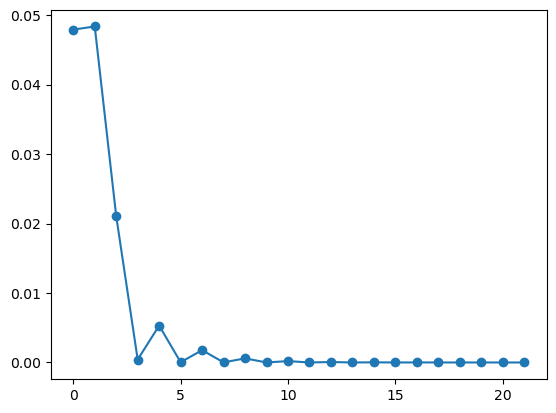

In [5]:
plt.plot(solver.power_res, '-o')

### **Unit cube**

In [9]:
# Crear el dominio
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 16, 16, 16)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('16 x 16 x16 Unit cube')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 32, 32, 32)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('32 x 32 x 32 Unit cube')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)


------------------------------------------------------------------------------
16 x 16 x16 Unit cube
k_eff                                                   : 0.009894914897569876
Number of iterations Dynamic Power Method with momentum : 9
CPU time                                                : 2.880569500000007
------------------------------------------------------------------------------
32 x 32 x 32 Unit cube
k_eff                                                   : 0.010013005457455607
Number of iterations Dynamic Power Method with momentum : 16
CPU time                                                : 477.05432734600004


In [10]:
# Crear el dominio
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 16, 16, 16)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod = 'slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('16 x 36 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 32, 32, 32)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod = 'slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('32x32x32 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

aca
aca2
------------------------------------------------------------------------------
16 x 36 Unit square
k_eff                                                   : (0.009894914857492457+0j)
CPU time                                                : 2.9178281460000335
aca
aca2
------------------------------------------------------------------------------
32x32x32 Unit square
k_eff                                                   : (0.010013005407561839+0j)
CPU time                                                : 150.44265549199997
